# <span style="color:#1111AA"> Michelson interferometer: Lengths and Tunings </span>

# Table of content

# 1.  Overview

## 1.1. Introduction

The aim of this session is to build a model of a Michelson interferometer, and investigate how its output depends on the macrospical lengths and microscopical tunings of its arms. The Michelson interferometer is the core of the interferometric GW detectors such as LIGO, Virgo, GEO and KAGRA.

## 1.2. Prerequisites and reading material

We recommend that you have done the following notebooks before starting this one:
* 01_Introduction
    * 01_Ipython_notebook
        * [01_Ipython_notebook](../../01_Introduction/01_Ipython_notebook/01_Ipython_notebook.ipynb)
    * 02_Finesse
        * [01_Introduction](../../01_Introduction/02_Finesse/01_Introduction.ipynb)
    * 03_Pykat
        * [01_Introduction](../../01_Introduction/03_Pykat/01_Introduction.ipynb)
        * [02_Plotting_Examples](../../01_Introduction/03_Pykat/02_Plotting_Examples.ipynb)

or have corresponding basic experience of Ipython notebooks, PyKat, and Finesse. The links above only works if you started ipython notebook in the top directory of this course.

**Reading material and references:**

[1] [A. Freise, K. Strain, D. Brown, and C. Bond, "Interferometer Techniques for Gravitational-Wave Detection", *Living Reviews in Relativity* **13**, 1 (2010)](http://arxiv.org/pdf/0909.3661v3).

[2] [A. Freise, D. Brown, and C. Bond, "Finesse, Frequency domain INterferomEter Simulation SoftwarE"](http://kvasir.sr.bham.ac.uk/redmine/attachments/download/131/Finesse_2.0_manual.pdf).

[3] [FINESSE syntax reference](http://www.gwoptics.org/finesse/reference/)

## 1.3. After this session you will be able to...

**After this session you will be able to**:
  * build a FINESSE-model of a Michelson interferometer.
  * calibrate the operating point of the FINESSE-model.

# 2.  Modelling a Michelson Interferometer using FINESSE

## 2.1. Importing packages

We start by loading some necessary packages:

In [2]:
import numpy as np                         # Importing numpy
import matplotlib                          # Importing matplotlib, so we can plot figures
import matplotlib.pyplot as plt                   
from pykat import finesse                  # Importing the pykat.finesse package
from pykat.commands import *               # Importing all packages in pykat.commands.
from IPython.display import display, HTML  # Allows us to display HTML.

# Telling the notebook to make plots inline.
%matplotlib inline      
# Initialises the PyKat plotting tool. Change the dpi-value to make plots appear smaller/bigger on your screen.
pykat.init_pykat_plotting(dpi=90)          

                                              ..-
    PyKat 0.8.10          _                  '(
                          \`.|\.__...-""""-_." )
       ..+-----.._        /  ' `            .-'
   . '            `:      7/* _/._\    \   (
  (        '::;;+;;:      `-"' =" /,`"" `) /
  L.        \`:::a:f            c_/     n_'
  ..`--...___`.  .    ,  
   `^-....____:   +.      www.gwoptics.org/pykat



## 2.2 Optical Layout

Below is the optical layout of a simple Michelson. The laser beam is splitted by the beam splitter (BS) and propagates in both X and Y arms. Gravitational wave detectors are calibrated such that when the two beams are recombined at the beam splitter, they interfere (close to) destructively at the output port (a.k.a. south port, assymetric port, dark port), and they intefere constructively at the west port (a.k.a. symmetric port, bright port). Mirror movements or gravitational waves change the differential arm lenghth $\Delta L = L_y - L_x$, which produces a signal at the output port where we place a photodiode. See section 5.2 in the review article if you want a longer description of the Michelson interferometer.

<img src="files/michelson.png" style="width: 500px;"/>

## 2.3.  Lengths and tunings

If the beams interfere constructively or destructively at the beam splitter depends on the difference in optical path lengths for the two arms, modulo the laser wavelength. Thus, for the light of a Nd:YAG laser ($\lambda = 1064$ nm), length differences of less than 1 μm are of interest. Some orders of magnitude:
  * LIGO peak senitivity in meters: $\sim 10^{-20}$ m
  * LIGO cavity mirror postion control accuracy: $< 10^{-12}$ m
  * LIGO arm cavity length: $\sim 10^3$ m
  * relative numerical accuracy of floating point numbers: $10^{-15}$

Because of the large differences in order of magntiude, it is convenient to split distances D between optical components into two parameters: one is the macroscopic ‘length’ L defined now as that multiple of the default wavelength $\lambda_0$ yielding the smallest difference to D. The second parameter is the microscopic tuning that is defined as the remaining difference between L and D. This tuning is usually given as a phase "phi" (in radians) with 2π referring to one wavelength. In FINESSE tunings are entered and printed in degrees, so that a tuning of phi = 360 degrees refers to a change in the position of the component by one wavelength ($\lambda_0$). In FINESSE macroscopical lengths are assigned to space components (keyword `s`) and microscopiacal tunings are assigned to optical components such as mirrors, beam splitters, lenes etc. You can read more about how lengths and tuning are defined in FINESSE in section 2.5 in Freise et al. [1]. 

## 2.4. Building the FINESSE-model

Lets build an optical model in FINESSE matching the setup in the figure above.

In [3]:
basekat = finesse.kat()    # Initialising Finesse
basekat.verbose = False    # Tells Finesse to talk less

basecode = """

## Parameters ##
const Pin 1M         # Laser power [W]
const LX 4000        # Length of X arm [m]
const LY 4000        # Length of Y arm [m]

## Laser & Beam splitter ##
l laser $Pin 0 n0                         # Laser
s s1 1 n0 nbsc                            # Space from laser to beam splitter
bs BS 0.5 0.5 0 45 nbsc nbsY nbsX nbsd    # Central 50/50 beam splitter with 0 tuning and 45 deg angle of incidence.

## X arm ##
s LX $LX nbsX nmX1         # Space between beam splitter and mirror mX
m mX 1 0 0 nmX1 nmX2       # Test mass mirror mX (reflectivity 1, 0 transmissivity, and 0 deg tuning)

## Y arm ##
s LY $LY nbsY nmY1         # Space between beam slitter and mirror mY
m mY 1 0 0 nmY1 nmY2       # Test mass mirror mY (reflectivity 1, 0 transmissivity, and 0 deg tuning)

## Output port ##
s sout 1 nbsd nout         # Space from BS to a measurement device not yet defined

"""
basekat.parseCommands(basecode)  # passing the input text to the Finesse object

We call this kat-object *basekat* since it describes the core optics of the system we will investigate throughout this notebook. The above basekat-object will not be altered much throughout the Notebooks about the Michelson interferometer, however, what we measure and the specific simulation instructions will. Therefore we can copy the above basekat objet by using `deepcopy`, and then add on the specific simulation instructions.

## 2.5. Differential arm length tuning

Now we add the simulation instrctions. Here we will look at how the output power varies with differential arm length (DARM) tuning. 

In [4]:
kat1 = deepcopy(basekat)
code = """

## Detectors ##
pd pout nout                     # Photo diode at the output port

## Simulation instructions ##

# Varying the differential arm length
xaxis mX phi lin -90 90 200      # Changes the parameter phi of mX from -90 to 90 in 200 linear steps. 

put* mY phi $mx1                  # Puts the negative (m in $mx1 is keyword for minus) value from the 
                                 # x-axis to the tuning of mY.
yaxis abs                        # Outputs the amplitude of their measured quantity.
"""
# Parsing the FINESSE code
kat1.parseCommands(code)
# Running the simulation
out1 = kat1.run()

The line `put* mY phi $mx1` might be new to you, here follows a short explanation: 

Parameters fronted by an `$` are internal variables in Finesse, so here `$mx1` refers to the current value of the xaxis times (-1). Without the `m` in front of `x1` there would be no factor of (-1). The put command sets the position paramter `phi` of mirror `mY` to this value. Therefore, by using the put command here, we elongate one arm while shortening the other. The star (*) after `put` adds tells FINESSE to add the value instead of instead of overwriting it, which would be the case without the star. In this case it doesn't matter which we use though, but we use the star here for convenience later.

## 2.4. Simulation output:

In [5]:
out1 = kat1.run() # run Finesse, the output will be stored in 'out1'

The result of the run is now stored in the object `out1`. We can plot the output by using:

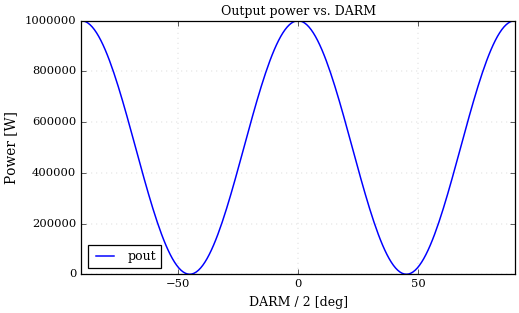

In [6]:
fig1 = out1.plot(xlabel="DARM / 2 [deg]", 
                 ylabel="Power [W]", 
                 title="Output power vs. DARM")

To add units on the y-axis we can use:

# 3. Your tasks: 

## 3.1. Calibrate the operating point to the dark fringe

For the current setup we have a power peak when not chaning anything, i.e., at zero on the x-axis in the figure above. But gravitational wave detectors operate close to the dark fringe, that is where the power is zero. Change **one** parameter in the setup to make the setup initillay yield zero output power.

**Answer:**

## 3.2. Detune the operating point

Your setup now yields 0 power if nothing is changed, however, the current gravitatitonal wave detctors don't operate exactly at the dark fringe, but sligthly off it. The reason for this lays outside the scope of this notebook: we need a *local oscillator* that beats with the signal sidebands, created in the the arms by gravitational waves, to see the the signal sidebands. Don't worry if you don't understand the former sentence.

Change the tuning slightly of one of the arm mirrors so that we get 10 mW as output. What length offset does this tuning offset corresponds to? Why not a larger number than 10 mW?

**Comment**: In case you want to use a <a href="http://docs.scipy.org/doc/scipy/reference/optimize.html">`scipy.optimize`</a> tool (I would suggest `minimize_scalar()` in that case), FINESSE need can be told to compute results for one data point per run by using the command `noxaxis` in the FINESSE-code, or by making use of PyKat by typing `kat.noxaxis=True`..

**Answer:**

# 3.3. Macroscopical arm length difference

Investigate the response of the Michelson interferometer to a change in the macroscopical arm length difference, i.e., change the lengths of the space components. What do you see and why?

**Answer:**

# 3.4. Macroscopical arm length difference and change in frequency

In FINESSE the frequency of a laser field can be specified in two different ways: 

* One can set the absolute frequency of the carrier laser field by specifiying the carrier wavelenght. This can be done either by chaning the paramter lambda in the *kat.ini* file located in your FINESSE directory, or by using the finesse code line '`lambda 1550n`', or in PyKat by using `kat.lambda0 = 1550.0e-9`. In the last 2 examples we used 1550 nm as the new wavelength. 

* One can specify a frequency offset relative to the carrier by setting the frequency offset paramter `f` of the laser component.

Your task it to change both the absolute frequency and the relative frequency, but in separate runs, and see how these parameters changes the result of task 3.3. What do you see, and why? 

*Hint: Remember that FINESSE defines macroscopical lengths as integer multiples of the carrier wavelength.*

**Answer:**

# 4. Summary

In this session we have:
* built a FINESSE model of a Michelson interferometer
* investigated how the power depends on the microscopical arm length difference
* calibrated the operating point to the dark fringe
* detuned the operating point to give a specific amount of output power. 
* investigated how the output power depends on the macroscopical arm length difference.
* investigated how the output power depends on the macroscopical arm length difference when we change the reference carrier frequency, and offset the laser frequency.

In the [next session](02_Mirror_asymmetries.ipynb) we will look into how the Michelson depends on Mirror asymmetries. 